In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
import tensorflow as tf

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

# Add channel dimension (to make it compatible with Conv2D layers)
x_train = x_train[..., None]
x_test = x_test[..., None]   

# Print the shapes of the datasets
print("Training data shape:", x_train.shape)  
print("Training labels shape:", y_train.shape) 
print("Test data shape:", x_test.shape) 
print("Test labels shape:", y_test.shape)  


Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


In [32]:
#Hyperparameters
BATCH_SIZE = 32
IMG_SIZE = 28
T = 1000    #Number of time steps
beta_start, beta_end = 1e-4, 0.02    #noise schedule
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)

alphas = 1- betas
alphas_cumprod = np.cumprod(alphas, axis=0)

In [38]:
def forward_diffusion(x_0, t, noise=None):
    if noise is None:
        noise = tf.random.normal(size=tf.shape(x_0))
    
    t = tf.convert_to_tensor(t, dtype=tf.int32) # Ensure t is a tensor
    mean = tf.gather(tf.sqrt(alphas_cumprod), t)[:, None, None, None] * x_0
    std = tf.gather(tf.sqrt(1 - alphas_cumprod), t)[:, None, None, None]
    return mean + std * noise, noise

In [34]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    output = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [57]:
def loss_function(model, x_0, t):
    noise = np.random.normal(size=tf.shape(x_0))
    x_t, true_noise = forward_diffusion(x_0, t, noise)
    pred_noise = model(x_t, training=True)
    return tf.reduce_mean(tf.square(pred_noise - true_noise))

def train(model, data, epochs=10, lr=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for x_0 in data:
            t = np.random.randint(0, T, size=(x_0.shape[0],))
            with tf.GradientTape() as tape:
                loss = loss_function(model, x_0, t)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_loss += loss.numpy()

        print(f"Epoch:{epoch+1}, Loss: {total_loss/len(data)}")


In [36]:
def sample(model, T, num_samples=10):
    x_T = tf.random.normal((num_samples, IMG_SIZE, IMG_SIZE, 1))

    for t in reversed(range(T)):
        noise_pred = model(x_T, training=False)
        alpha_t = alphas[t]
        alphas_cumprod_t = alphas_cumprod[t]
        beta_t = betas[t]
        x_T  = 1/np.sqrt(alpha_t) * (x_T - (beta_t / np.sqrt(1 - alphas_cumprod_t)) * noise_pred) 

        if t > 0:
            noise = np.random.normal(size=x_T.shape)
            x_T += np.sqrt(beta_t) * noise
        
        return (x_T + 1) / 2
     

In [ ]:
#get data for class 1
x_train_1 = np.array([x_train[i] for i in range(len(x_train)) if y_train[i] == 1])

In [61]:
model = build_model()
train(model, x_train_1[0:1000], epochs=2)

Epoch:1, Loss: 1.0015016257166862
Epoch:2, Loss: 1.0006509772539138


In [44]:
generated_samples = sample(model, T, num_samples=10)
print(generated_samples.shape)

(10, 28, 28, 1)


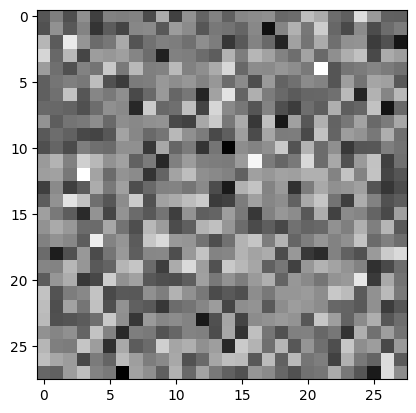

In [62]:
plt.imshow(generated_samples[0], cmap='gray')